# Machine Learning in Big Data with Apache Spark

 📌 In this section, we will predict Test customer churn using apache spark machine learning algorithms. 

# Business Problem

📌 It is desirable to develop a machine learning model that can predict customers who will leave the company. Before developing the model, you are expected to perform the necessary data analysis and feature engineering steps.

# Dataset Story

📌 Test churn data includes information about a fictitious telecom company that provided home phone and Internet services to 900 xxx customers.

# Create Session in Spark

In [1]:
!pip install findspark
import findspark
findspark.init("C:\spark")
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext
spark = SparkSession.builder \
    .master("local") \
    .appName("Churn_Modeling") \
    .getOrCreate()
sc = spark.sparkContext

In [2]:
sc

<SparkContext master=local appName=Churn_Modeling>

# Import Necesaary Libraries

In [73]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
from pyspark.sql.functions import col,isnan, when, count
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import Dataset

In [4]:
spark_df = spark.read.csv("churn.csv", header=True, inferSchema=True, sep=",")
spark_df.cache()

DataFrame[_c0: int, Names: string, Age: int, Total_Purchase: double, Account_Manager: int, Years: double, Num_Sites: int, Churn: string]

In [5]:
# show dataframe - 5 row
spark_df.show(5)

+---+----------------+---+--------------+---------------+-----+---------+-----+
|_c0|           Names|Age|Total_Purchase|Account_Manager|Years|Num_Sites|Churn|
+---+----------------+---+--------------+---------------+-----+---------+-----+
|  0|Cameron Williams| 42|       11066.8|              0| 7.22|        8|  Yes|
|  1|   Kevin Mueller| 41|      11916.22|              0|  6.5|       11|  Yes|
|  2|     Eric Lozano| 38|      12884.75|              0| 6.67|       12|  Yes|
|  3|   Phillip White| 42|       8010.76|              0| 6.71|       10|  Yes|
|  4|  Cynthia Norton| 37|       9191.58|              0| 5.56|        9|  Yes|
+---+----------------+---+--------------+---------------+-----+---------+-----+
only showing top 5 rows



In [6]:
# show column name with data types
spark_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Names: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: integer (nullable = true)
 |-- Churn: string (nullable = true)



In [7]:
# show data types features
spark_df.dtypes

[('_c0', 'int'),
 ('Names', 'string'),
 ('Age', 'int'),
 ('Total_Purchase', 'double'),
 ('Account_Manager', 'int'),
 ('Years', 'double'),
 ('Num_Sites', 'int'),
 ('Churn', 'string')]

In [8]:
# rename variable neames
spark_df = spark_df.withColumnRenamed("_c0","index")
spark_df.show(3)

+-----+----------------+---+--------------+---------------+-----+---------+-----+
|index|           Names|Age|Total_Purchase|Account_Manager|Years|Num_Sites|Churn|
+-----+----------------+---+--------------+---------------+-----+---------+-----+
|    0|Cameron Williams| 42|       11066.8|              0| 7.22|        8|  Yes|
|    1|   Kevin Mueller| 41|      11916.22|              0|  6.5|       11|  Yes|
|    2|     Eric Lozano| 38|      12884.75|              0| 6.67|       12|  Yes|
+-----+----------------+---+--------------+---------------+-----+---------+-----+
only showing top 3 rows



In [9]:
# change column name to lowercase
spark_df = spark_df.toDF(*[c.lower() for c in spark_df.columns])
spark_df.columns

['index',
 'names',
 'age',
 'total_purchase',
 'account_manager',
 'years',
 'num_sites',
 'churn']

In [10]:
# how to define function in spark and use it
def upperCase(y):
    return y.upper()

upperCaseUDF = udf(lambda x:upperCase(x),StringType()) 

spark_df.withColumn("churn", upperCaseUDF(col("churn"))).show(3)

+-----+----------------+---+--------------+---------------+-----+---------+-----+
|index|           names|age|total_purchase|account_manager|years|num_sites|churn|
+-----+----------------+---+--------------+---------------+-----+---------+-----+
|    0|Cameron Williams| 42|       11066.8|              0| 7.22|        8|  YES|
|    1|   Kevin Mueller| 41|      11916.22|              0|  6.5|       11|  YES|
|    2|     Eric Lozano| 38|      12884.75|              0| 6.67|       12|  YES|
+-----+----------------+---+--------------+---------------+-----+---------+-----+
only showing top 3 rows



In [11]:
# define label encoder function
def labelEncoder(y):
    if y=="Yes":
        y=1
    else:
        y=0
    return y

from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
labelEncoderUDF = udf(lambda x:labelEncoder(x),StringType()) 

spark_df = spark_df.withColumn("churn", labelEncoderUDF(col("churn")))
spark_df.show(3)

+-----+----------------+---+--------------+---------------+-----+---------+-----+
|index|           names|age|total_purchase|account_manager|years|num_sites|churn|
+-----+----------------+---+--------------+---------------+-----+---------+-----+
|    0|Cameron Williams| 42|       11066.8|              0| 7.22|        8|    1|
|    1|   Kevin Mueller| 41|      11916.22|              0|  6.5|       11|    1|
|    2|     Eric Lozano| 38|      12884.75|              0| 6.67|       12|    1|
+-----+----------------+---+--------------+---------------+-----+---------+-----+
only showing top 3 rows



In [12]:
# change data type ==> string to int using withColumn function
spark_df = spark_df.withColumn("churn",spark_df["churn"].cast("int"))
spark_df = spark_df.withColumn("index",spark_df["index"].cast("string"))

# General Information About to the Dataset

In [13]:
# shape of dataset
print((spark_df.count(), len(spark_df.columns)))

(900, 8)


In [14]:
# describe dataset
spark_df.select([col[0] for col in spark_df.dtypes if col[1] != 'string']).describe().show()

+-------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|summary|              age|   total_purchase|   account_manager|            years|         num_sites|              churn|
+-------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|  count|              900|              900|               900|              900|               900|                900|
|   mean|41.81666666666667|10062.82403333334|0.4811111111111111| 5.27315555555555| 8.587777777777777|0.16666666666666666|
| stddev|6.127560416916251|2408.644531858096|0.4999208935073339|1.274449013194616|1.7648355920350969| 0.3728852122772358|
|    min|               22|            100.0|                 0|              1.0|                 3|                  0|
|    max|               65|         18026.01|                 1|             9.15|                14|                  1|
+-------+---------------

In [15]:
# describe pandas
spark_df.select([col[0] for col in spark_df.dtypes if col[1] != 'string']).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,900,41.81666666666667,6.127560416916251,22,65
total_purchase,900,10062.82403333334,2408.644531858096,100.0,18026.01
account_manager,900,0.4811111111111111,0.4999208935073339,0,1
years,900,5.27315555555555,1.274449013194616,1.0,9.15
num_sites,900,8.587777777777777,1.7648355920350969,3,14
churn,900,0.16666666666666666,0.3728852122772358,0,1


In [16]:
# Null data
spark_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in spark_df.columns]).show()

+-----+-----+---+--------------+---------------+-----+---------+-----+
|index|names|age|total_purchase|account_manager|years|num_sites|churn|
+-----+-----+---+--------------+---------------+-----+---------+-----+
|    0|    0|  0|             0|              0|    0|        0|    0|
+-----+-----+---+--------------+---------------+-----+---------+-----+



In [17]:
# distinct row
spark_df.distinct().count()

900

In [18]:
# distinct names
spark_df.select("names").distinct().count()

899

In [19]:
# groupby
spark_df.groupby("names").count().sort("count", ascending=False).show(3)

+-------------+-----+
|        names|count|
+-------------+-----+
|Jennifer Wood|    2|
| Patrick Bell|    1|
|Chelsea Marsh|    1|
+-------------+-----+
only showing top 3 rows



In [20]:
# filter
spark_df.filter(spark_df.names=="Jennifer Wood").show()

+-----+-------------+---+--------------+---------------+-----+---------+-----+
|index|        names|age|total_purchase|account_manager|years|num_sites|churn|
+-----+-------------+---+--------------+---------------+-----+---------+-----+
|   22|Jennifer Wood| 35|       9381.12|              1| 6.78|       11|    1|
|  439|Jennifer Wood| 48|      11585.16|              0| 4.61|        9|    0|
+-----+-------------+---+--------------+---------------+-----+---------+-----+



In [21]:
# drop duplicates
spark_df.select("names").dropDuplicates().groupby("names").count().sort("count", ascending=False).show(3)

+----------------+-----+
|           names|count|
+----------------+-----+
|    Patrick Bell|    1|
|Patrick Robinson|    1|
|   Chelsea Marsh|    1|
+----------------+-----+
only showing top 3 rows



In [22]:
# where
spark_df.where(spark_df.index==439).show()

+-----+-------------+---+--------------+---------------+-----+---------+-----+
|index|        names|age|total_purchase|account_manager|years|num_sites|churn|
+-----+-------------+---+--------------+---------------+-----+---------+-----+
|  439|Jennifer Wood| 48|      11585.16|              0| 4.61|        9|    0|
+-----+-------------+---+--------------+---------------+-----+---------+-----+



In [23]:
# collect
spark_df.where(spark_df.index==439).collect()[0]["names"]

'Jennifer Wood'

# Exploratory Data Analysis(EDA)

In [24]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = spark_df.select([col for col in spark_df.columns if spark_df.select(col).dtypes[0][1] == "string"])
    num_but_cat = spark_df.select([col for col in spark_df.columns if spark_df.select(col).distinct().count() < cat_th and spark_df.select(col).dtypes[0][1] in ["int","double"]])
    cat_but_car = spark_df.select([col for col in spark_df.columns if spark_df.select(col).distinct().count() > car_th and spark_df.select(col).dtypes[0][1] == "string"])
    cat_cols = cat_cols.unionByName(num_but_cat, allowMissingColumns=True)
    cat_cols = cat_cols.select([col for col in cat_cols.columns if col not in cat_but_car.columns])
    num_cols = spark_df.select([col for col in spark_df.columns if spark_df.select(col).dtypes[0][1] in ["int","double"]])
    num_cols = num_cols.select([col for col in num_cols.columns if col not in cat_cols.columns])
    
    return cat_cols, num_cols, cat_but_car

In [25]:
cat_cols, num_cols, cat_but_car = grab_col_names(spark_df)

#Print Categorical and Numerical Variables
print(f"Observations: {spark_df.count()}")
print(f"Variables: {len(spark_df.columns)}")
print(f"Cat_cols: {len(cat_cols.columns)}")
print(f"Num_cols: {len(num_cols.columns)}")
print(f"Cat_but_car: {len(cat_but_car.columns)}")

Observations: 900
Variables: 8
Cat_cols: 2
Num_cols: 4
Cat_but_car: 2


In [26]:
# selection of all numeric variables and summary statistics
spark_df.select(num_cols.columns).describe().show()

+-------+-----------------+-----------------+-----------------+------------------+
|summary|              age|   total_purchase|            years|         num_sites|
+-------+-----------------+-----------------+-----------------+------------------+
|  count|              900|              900|              900|               900|
|   mean|41.81666666666667|10062.82403333334| 5.27315555555555| 8.587777777777777|
| stddev|6.127560416916251|2408.644531858096|1.274449013194616|1.7648355920350969|
|    min|               22|            100.0|              1.0|                 3|
|    max|               65|         18026.01|             9.15|                14|
+-------+-----------------+-----------------+-----------------+------------------+



In [27]:
# mean of numeric variables relative to target variable
for col in num_cols.columns:
    spark_df.groupby("churn").agg({col: "mean"}).show()

+-----+-----------------+
|churn|         avg(age)|
+-----+-----------------+
|    1|42.99333333333333|
|    0|41.58133333333333|
+-----+-----------------+

+-----+-------------------+
|churn|avg(total_purchase)|
+-----+-------------------+
|    1| 10192.179933333337|
|    0| 10036.952853333332|
+-----+-------------------+

+-----+------------------+
|churn|        avg(years)|
+-----+------------------+
|    1|5.8835999999999995|
|    0|5.1510666666666625|
+-----+------------------+

+-----+-----------------+
|churn|   avg(num_sites)|
+-----+-----------------+
|    1|            10.66|
|    0|8.173333333333334|
+-----+-----------------+



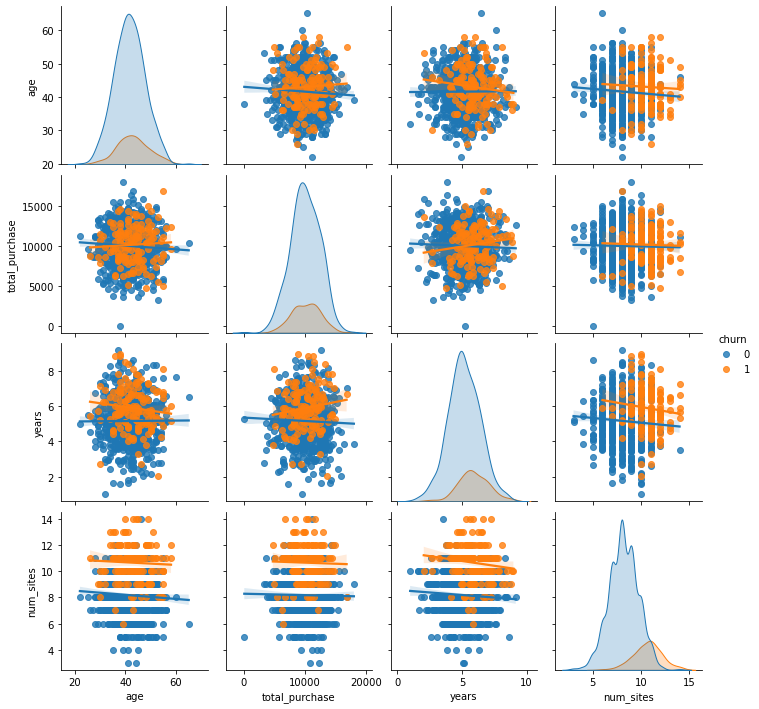

In [28]:
sns.pairplot(spark_df.toPandas(), vars=["age","total_purchase","years","num_sites"], hue="churn", kind="reg");

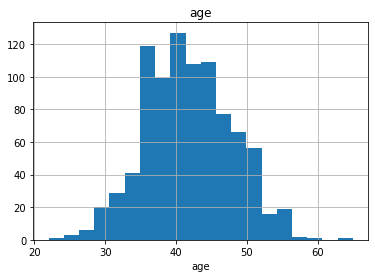

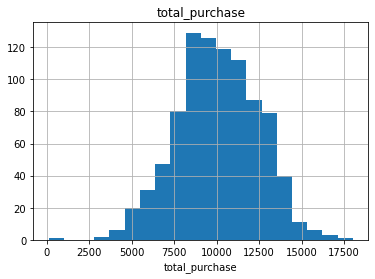

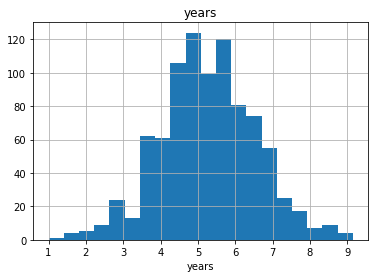

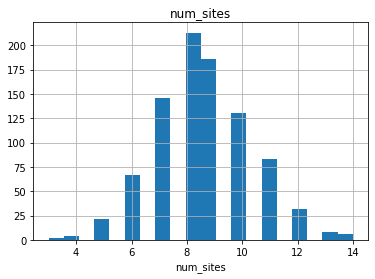

In [29]:
# numerical summary
for col in num_cols.columns:
    spark_df.select(col).toPandas().hist(bins=20)
    plt.xlabel(col)
    plt.title(col)
    plt.show(block=True)

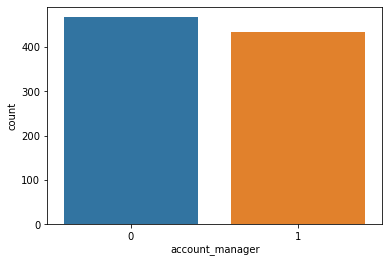

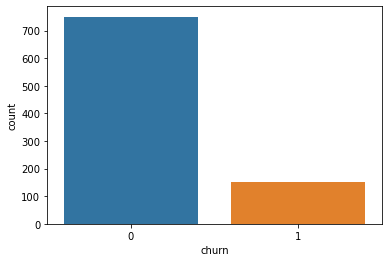

In [30]:
# categorical summary
for col in cat_cols.columns:
    sns.countplot(x=col,data=spark_df.toPandas())
    plt.show(block=True)

# Missing Value Analysis

In [31]:
# Null data
spark_df.select([count(when(isnan(c), c)).alias(c) for c in spark_df.columns]).show()

+-----+-----+---+--------------+---------------+-----+---------+-----+
|index|names|age|total_purchase|account_manager|years|num_sites|churn|
+-----+-----+---+--------------+---------------+-----+---------+-----+
|    0|    0|  0|             0|              0|    0|        0|    0|
+-----+-----+---+--------------+---------------+-----+---------+-----+



# Creating Spark DataFrame Structure

📌 Creating DataFrame Structure for Machine Learning Algorithms in Spark

In [32]:
# independent variable
indexed = StringIndexer(inputCol="churn", outputCol="label").fit(spark_df).transform(spark_df)
spark_df = indexed.withColumn("label", indexed["label"].cast("Integer"))

In [33]:
spark_df.dtypes

[('index', 'string'),
 ('names', 'string'),
 ('age', 'int'),
 ('total_purchase', 'double'),
 ('account_manager', 'int'),
 ('years', 'double'),
 ('num_sites', 'int'),
 ('churn', 'int'),
 ('label', 'int')]

In [39]:
# dependent variable
dependent_variables = spark_df.select([col for col in spark_df.columns if col not in ["index","names","churn","label"]])
va_df = VectorAssembler(inputCols=dependent_variables.columns, outputCol="features").transform(spark_df)

In [44]:
va_df.dtypes

[('index', 'string'),
 ('names', 'string'),
 ('age', 'int'),
 ('total_purchase', 'double'),
 ('account_manager', 'int'),
 ('years', 'double'),
 ('num_sites', 'int'),
 ('churn', 'int'),
 ('label', 'int'),
 ('features', 'vector')]

In [46]:
final_df = va_df.select(["features","label"])
final_df.show(10)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[42.0,11066.8,0.0...|    1|
|[41.0,11916.22,0....|    1|
|[38.0,12884.75,0....|    1|
|[42.0,8010.76,0.0...|    1|
|[37.0,9191.58,0.0...|    1|
|[48.0,10356.02,0....|    1|
|[44.0,11331.58,1....|    1|
|[32.0,9885.12,1.0...|    1|
|[43.0,14062.6,1.0...|    1|
|[40.0,8066.94,1.0...|    1|
+--------------------+-----+
only showing top 10 rows



In [47]:
# Train-Test Split
splits = final_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

# Create Model

📌 Customer Churn Modeling with Gradient Boosting Machine(GBM) in Spark

In [54]:
gbm = GBTClassifier(maxIter=10, featuresCol="features", labelCol="label")
gbm_model = gbm.fit(train_df)

In [55]:
y_pred = gbm_model.transform(test_df)
y_pred.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[25.0,9672.03,0.0...|    0|[1.33329365744251...|[0.93502601022891...|       0.0|
|[28.0,8670.98,0.0...|    0|[1.31858747141050...|[0.93321611146053...|       0.0|
|[28.0,11204.23,0....|    0|[1.33554461206683...|[0.93529897683538...|       0.0|
|[29.0,8688.17,1.0...|    1|[0.85115442103402...|[0.84583604244687...|       0.0|
|[29.0,9378.24,0.0...|    0|[1.31858747141050...|[0.93321611146053...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [59]:
acc = y_pred.select("label", "prediction")
print("Accuracy: " , acc.filter(acc.label == acc.prediction).count() / acc.count())

Accuracy:  0.8708487084870848


In [64]:
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName='areaUnderROC')
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
acc = evaluatorMulti.evaluate(y_pred, {evaluatorMulti.metricName: "accuracy"})
precision = evaluatorMulti.evaluate(y_pred, {evaluatorMulti.metricName: "precisionByLabel"})
recall = evaluatorMulti.evaluate(y_pred, {evaluatorMulti.metricName: "recallByLabel"})
f1 = evaluatorMulti.evaluate(y_pred, {evaluatorMulti.metricName: "f1"})
roc_auc = evaluator.evaluate(y_pred)
print("accuracy: %f, precision: %f, recall: %f, f1: %f, roc_auc: %f" % (acc, precision, recall, f1, roc_auc))

accuracy: 0.870849, precision: 0.895833, recall: 0.955556, f1: 0.860352, roc_auc: 0.706039


# Model Tuning

In [65]:
evaluator = BinaryClassificationEvaluator()
paramGrid = (ParamGridBuilder()
             .addGrid(gbm.maxDepth, [2, 4, 6])
             .addGrid(gbm.maxBins, [20, 30])
             .addGrid(gbm.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbm,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=10)

In [66]:
cv_model = cv.fit(train_df)

In [68]:
y_pred = cv_model.transform(test_df)
y_pred.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[25.0,9672.03,0.0...|    0|[1.46788378712118...|[0.94958649731500...|       0.0|
|[28.0,8670.98,0.0...|    0|[1.46788378712118...|[0.94958649731500...|       0.0|
|[28.0,11204.23,0....|    0|[0.83828727412141...|[0.84245041187600...|       0.0|
|[29.0,8688.17,1.0...|    1|[1.01911109100682...|[0.88475211526343...|       0.0|
|[29.0,9378.24,0.0...|    0|[1.46788378712118...|[0.94958649731500...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [69]:
acc = y_pred.select("label", "prediction")
print("Accuracy: " , acc.filter(acc.label == acc.prediction).count() / acc.count())

Accuracy:  0.8966789667896679


In [71]:
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName='areaUnderROC')
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
acc = evaluatorMulti.evaluate(y_pred, {evaluatorMulti.metricName: "accuracy"})
precision = evaluatorMulti.evaluate(y_pred, {evaluatorMulti.metricName: "precisionByLabel"})
recall = evaluatorMulti.evaluate(y_pred, {evaluatorMulti.metricName: "recallByLabel"})
f1 = evaluatorMulti.evaluate(y_pred, {evaluatorMulti.metricName: "f1"})
roc_auc = evaluator.evaluate(y_pred)
print("accuracy: %f, precision: %f, recall: %f, f1: %f, roc_auc: %f" % (acc, precision, recall, f1, roc_auc))

accuracy: 0.896679, precision: 0.905350, recall: 0.977778, f1: 0.886100, roc_auc: 0.738889


# Predictions - New Customers

In [81]:
names = pd.Series(["Ali","Ahmet","Muhammed","Zeynep","Leyla","Ahu"])
age = pd.Series([25,20,45,35,29,52])
total_purchase = pd.Series([3000,5000,4500,10000,25500,60000])
account_manager = pd.Series([1,1,0,1,0,1])
years = pd.Series([5,3,10,15,2,20])
num_sites = pd.Series([40,10,15,20,32,18])
new_customers = pd.DataFrame({
    "names":names,
    "age":age,
    "total_purchase":total_purchase,
    "account_manager":account_manager,
    "years":years,
    "num_sites":num_sites})
new_customers.columns

Index(['names', 'age', 'total_purchase', 'account_manager', 'years',
       'num_sites'],
      dtype='object')

In [82]:
new_customers

,names,age,total_purchase,account_manager,years,num_sites
0,Ali,25,3000,1,5,40
1,Ahmet,20,5000,1,3,10
2,Muhammed,45,4500,0,10,15
3,Zeynep,35,10000,1,15,20
4,Leyla,29,25500,0,2,32
5,Ahu,52,60000,1,20,18


In [83]:
new_sdf = spark.createDataFrame(new_customers)

In [84]:
new_sdf.show()

+--------+---+--------------+---------------+-----+---------+
|   names|age|total_purchase|account_manager|years|num_sites|
+--------+---+--------------+---------------+-----+---------+
|     Ali| 25|          3000|              1|    5|       40|
|   Ahmet| 20|          5000|              1|    3|       10|
|Muhammed| 45|          4500|              0|   10|       15|
|  Zeynep| 35|         10000|              1|   15|       20|
|   Leyla| 29|         25500|              0|    2|       32|
|     Ahu| 52|         60000|              1|   20|       18|
+--------+---+--------------+---------------+-----+---------+



In [85]:
# dependent variable
dependent_variables = new_sdf.select([col for col in spark_df.columns if col not in ["index","names","churn","label"]])
va_df = VectorAssembler(inputCols=dependent_variables.columns, outputCol="features").transform(new_sdf)

In [87]:
va_df.show()

+--------+---+--------------+---------------+-----+---------+--------------------+
|   names|age|total_purchase|account_manager|years|num_sites|            features|
+--------+---+--------------+---------------+-----+---------+--------------------+
|     Ali| 25|          3000|              1|    5|       40|[25.0,3000.0,1.0,...|
|   Ahmet| 20|          5000|              1|    3|       10|[20.0,5000.0,1.0,...|
|Muhammed| 45|          4500|              0|   10|       15|[45.0,4500.0,0.0,...|
|  Zeynep| 35|         10000|              1|   15|       20|[35.0,10000.0,1.0...|
|   Leyla| 29|         25500|              0|    2|       32|[29.0,25500.0,0.0...|
|     Ahu| 52|         60000|              1|   20|       18|[52.0,60000.0,1.0...|
+--------+---+--------------+---------------+-----+---------+--------------------+



In [88]:
results = cv_model.transform(va_df)
results.select("names","prediction").show()

+--------+----------+
|   names|prediction|
+--------+----------+
|     Ali|       1.0|
|   Ahmet|       0.0|
|Muhammed|       1.0|
|  Zeynep|       1.0|
|   Leyla|       0.0|
|     Ahu|       1.0|
+--------+----------+



In [98]:
# save prediction results
results.select("names","prediction").toPandas().to_csv("results.csv")